# Auswirkungen von Überschriften auf den Aktienkurs
<br>
<b>In diesem Notebook wird versucht eine Beziehung zwischen Überschriften von Nachrichten über Aktien (Aktiennews) und den dazu gehörigen Aktienpreisen darzustellen und zu belegen.</b><br>
Dazu wird ein Datensatzes von bot_developer <a href="https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests">Daily Financial News for 6000+ Stocks, Kaggle</a> mit Headlines zu Stocks sowie die Aktienpreise, bezogen durch eine API von <a href="https://www.polygon.io">Polygon.io</a>, herangezogen.
<br><br>
<i>Im folgenden wird nach dem CRISP-DM vorgegangen.</i>
<br><br>
@author DHR <br>
@author BKN <br>
Stand: 17.08.2021

## Requirements
Zur Installation aller benötigten Module nutzen Sie<br>
<code>python -m pip install -r requirements.txt</code><br>
<i>Es wird die verwendung eines virtuellen Enviroments empfohlen</i>

In [40]:
# basic Python Modules
import os
import random
import datetime
import time

# basic DataScience Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
# basic Data Understanding
import statistics

# basic visualization for Data Understanding
from wordcloud import WordCloud

In [42]:
# headline cleaning
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

from sentistrength import PySentiStr
# from stanfordcorenlp import StanfordCoreNLP
# nlp = StanfordCoreNLP(r'G:\JavaLibraries\stanford-corenlp-full-2018-02-27')


[nltk_data] Downloading package wordnet to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dominik Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [43]:
# api requirements
from polygon import RESTClient
from dotenv import load_dotenv
load_dotenv()

def unique(l):
    ## list of only the unique values from a given list
    x = np.array(l)
    return np.unique(x)

In [ ]:
# Sentiment Modelling, Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# tf-idf Modelling

In [44]:
# load the Dataset as pandas DataFrame
"""
bot_developer, Daily Financial News for 6000+ Stocks; Kaggle: (https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests)
"""
data = pd.read_csv('../data/raw_analyst_ratings.csv')

## Data Understanding

Die Daten wurden bisher nicht von uns bereinigt.

### First Look

In [45]:
# first Look
print(data.columns)
data.sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


id                                           headline  \
77618      78364  Arista Hit Hard On Q4 Sales Warning: Is Facebo...   
1291165  1297341  Benzinga's Top Pre-Market NASDAQ Losers (URBN,...   
570302    573331  CORRECTION: Imperial Capital Maintains Outperf...   
612043    615221  Hill International Announces $54M Contract fro...   
972328    977229  Mid-Day Market Update: Delta Shares Gain On Up...   
424383    426655  Enzo Biochemical Files For $50M Mixed Shelf Of...   
367296    369326         5 Biggest Price Target Changes For Tuesday   

                                                       url          publisher  \
77618    https://www.benzinga.com/analyst-ratings/analy...   Shanthi Rexaline   
1291165  https://www.benzinga.com/news/11/03/910334/ben...         Lisa Levin   
570302   https://www.benzinga.com/news/20/05/15997695/c...  Benzinga_Newsdesk   
612043   https://www.benzinga.com/news/13/11/4102818/hi...      Charles Gross   
972328   https://www.benzinga.com/news/earnings/14/04/4...      Jake L'Ecuyer   
424383   https://www.benzinga.com/news/16/09/8417905/en...         Hal Lindon   
367296   https://www.benzinga.com/analyst-ratings/price...         Lisa Levin   

                              date stock  
77618          2019-11-01 00:00:00  ANET  
1291165        2011-03-08 00:00:00  URBN  
570302   2020-05-11 06:26:21-04:00  GPOR  
612043         2013-11-22 00:00:00   HIL  
972328         2014-04-23 00:00:00   PAM  
424383         2016-09-01 00:00:00   ENZ  
367296         2017-11-14 00:00:00  DLTR

In [46]:
# some statistics about the DataFrame
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))
data.count()

observations: 1407328, features: 6 

unique headlines: 845770, unique stocks: 6204 



id           1407328
headline     1407328
url          1407328
publisher    1407328
date         1407328
stock        1407328
dtype: int64

In [47]:
# group by the stocks
stock = data.groupby("stock")
stock.sample()

id                                           headline  \
236          236            7 Stocks To Watch For November 20, 2017   
4119        4538  Stock Market News for January 08, 2010 - Marke...   
4222        4651      60 Stocks Moving In Tuesday's Mid-Day Session   
4335        4764           3 ADR ETFs Your Broker Forgot to Mention   
4723        5163  American Air Reports Mar. Traffic: RPMs Down 1...   
...          ...                                                ...   
1405511  1412032  The Zweig Fund & Zweig Total Return Fund Appro...   
1405564  1412085           Stocks That Hit 52-Week Highs On Tuesday   
1406169  1412690              CNBC's Stock Pops & Drops From May 11   
1407143  1413664           Piper Jaffray Raises PT On Zumiez To $34   
1407322  1413843  China Zenix Auto International Selected as Exc...   

                                                       url      publisher  \
236      https://www.benzinga.com/news/earnings/17/11/1...     Lisa Levin   
4119     https://www.benzinga.com/81138/stock-market-ne...          Zacks   
4222     https://www.benzinga.com/news/18/11/12641505/6...     Lisa Levin   
4335     https://www.benzinga.com/trading-ideas/long-id...  ETF Professor   
4723     https://www.benzinga.com/news/17/04/9286714/am...  Paul Quintaro   
...                                                    ...            ...   
1405511  https://www.benzinga.com/news/16/04/7791199/th...     Hal Lindon   
1405564  https://www.benzinga.com/news/20/02/15300466/s...     Lisa Levin   
1406169  https://www.benzinga.com/media/cnbc/15/05/5500...    Craig Jones   
1407143  https://www.benzinga.com/analyst-ratings/11/05...      Joe Young   
1407322  https://www.benzinga.com/news/11/11/2142369/ch...   Eddie Staley   

                              date stock  
236            2017-11-20 00:00:00     A  
4119           2010-01-08 00:00:00    AA  
4222           2018-11-06 00:00:00   AAC  
4335     2013-03-05 15:42:46-04:00  AADR  
4723           2017-04-11 00:00:00   AAL  
...                            ...   ...  
1405511  2016-04-01 15:25:45-04:00   ZTR  
1405564        2020-02-11 00:00:00   ZTS  
1406169        2015-05-12 00:00:00    ZU  
1407143        2011-05-20 00:00:00  ZUMZ  
1407322        2011-11-21 00:00:00    ZX  

[6204 rows x 6 columns]

#### Range of Date

In [48]:
# Range of Date
print("Der Datensatz erstreckt sich über einen Datumsspanne vom "+ data['date'].min()[0:10] +" bis zum "+ data['date'].max()[0:10] +"\nDabei besteht der Datensatz aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich über einen Datumsspanne vom 2009-02-14 bis zum 2020-06-11
Dabei besteht der Datensatz aus 1407328 Einträgen


In [49]:
date_withYear = data.assign(year = lambda dataframe: dataframe['date'].map(lambda date: date[0:4]))

Text(0, 0.5, 'Number of Healines')

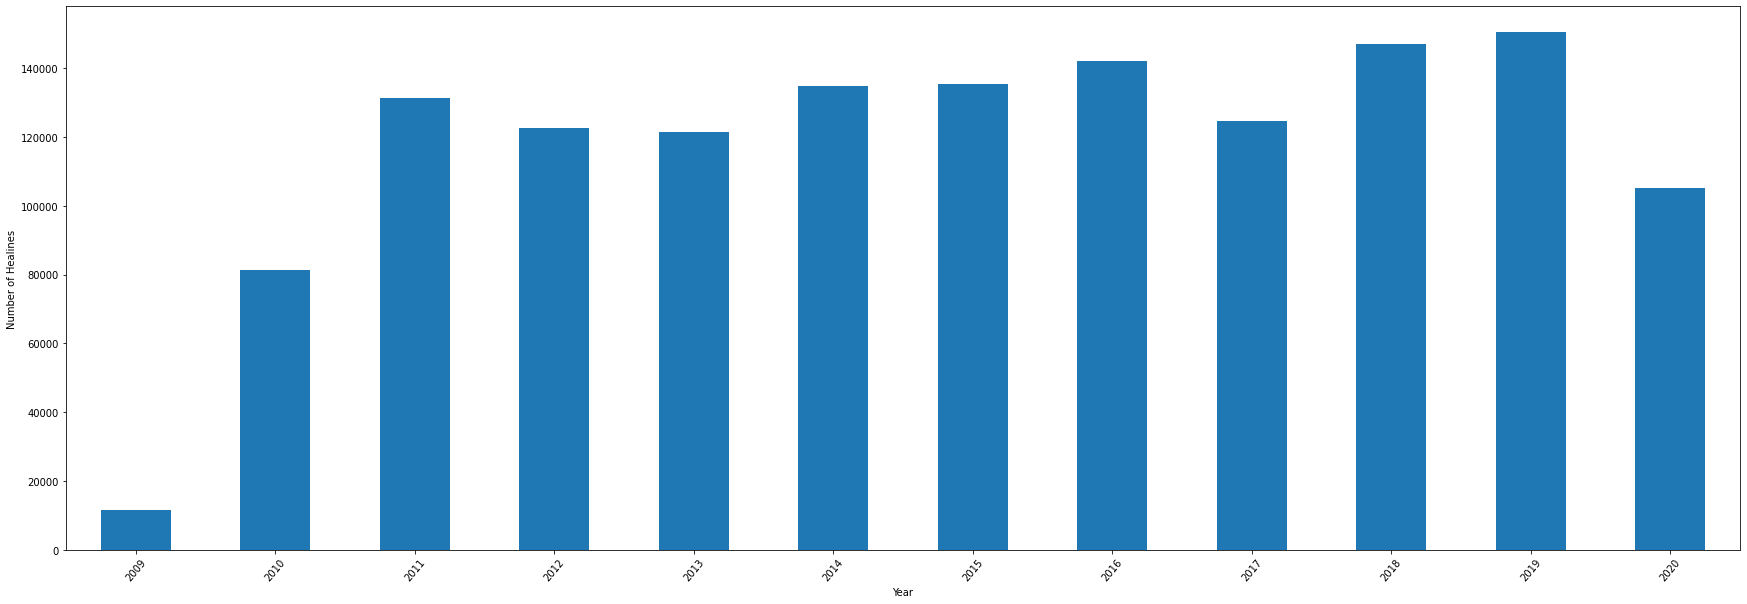

In [50]:
# Number of Date by Year
year = date_withYear.groupby("year")

plt.figure(figsize=(30,10))
year.size().plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Year")
plt.ylabel("Number of Healines")

In [51]:
# Average Count of Headlines by Year
print('Durchschnittliche Anzahl an Aktiennews über die Jahr: ', statistics.mean(year.size()))

Durchschnittliche Anzahl an Aktiennews über die Jahr:  117277.33333333333


### Data Visualization

Verteilung und Menge

<AxesSubplot:>

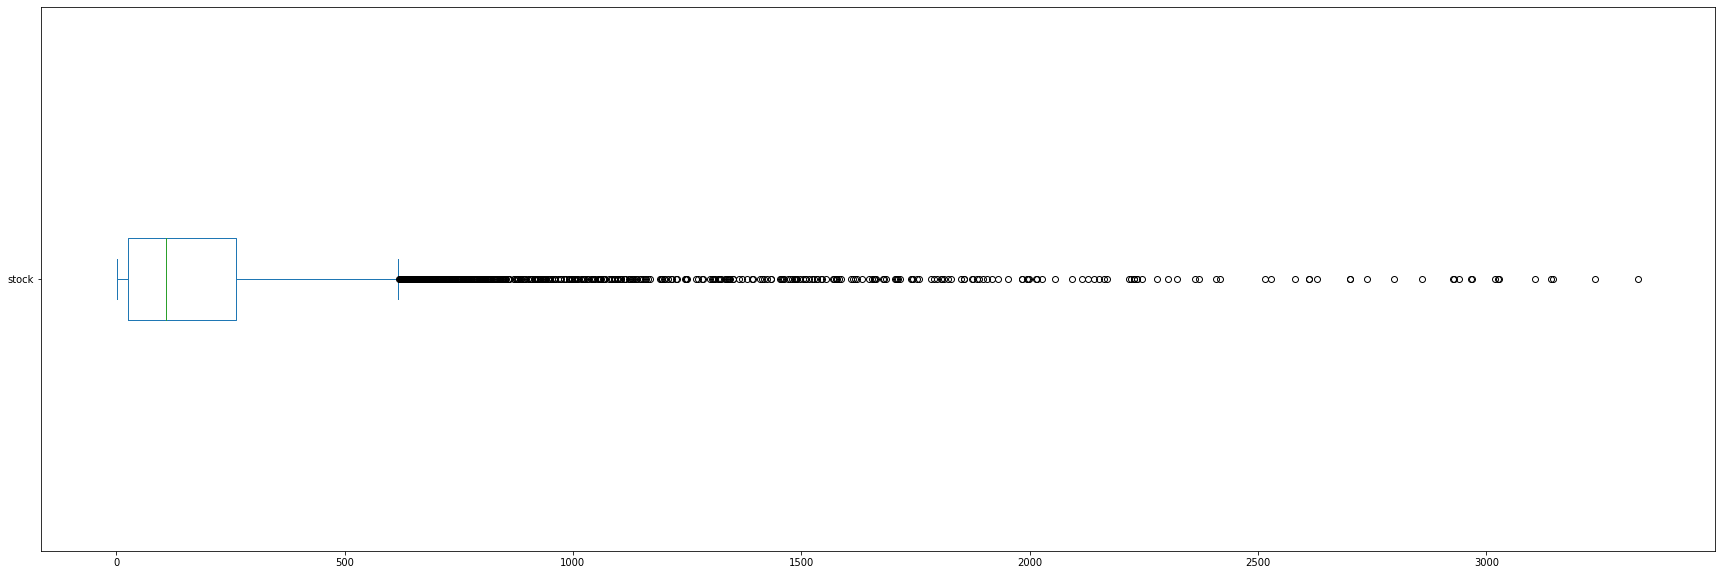

In [52]:
# BoxPlot of Stocks
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

<AxesSubplot:>

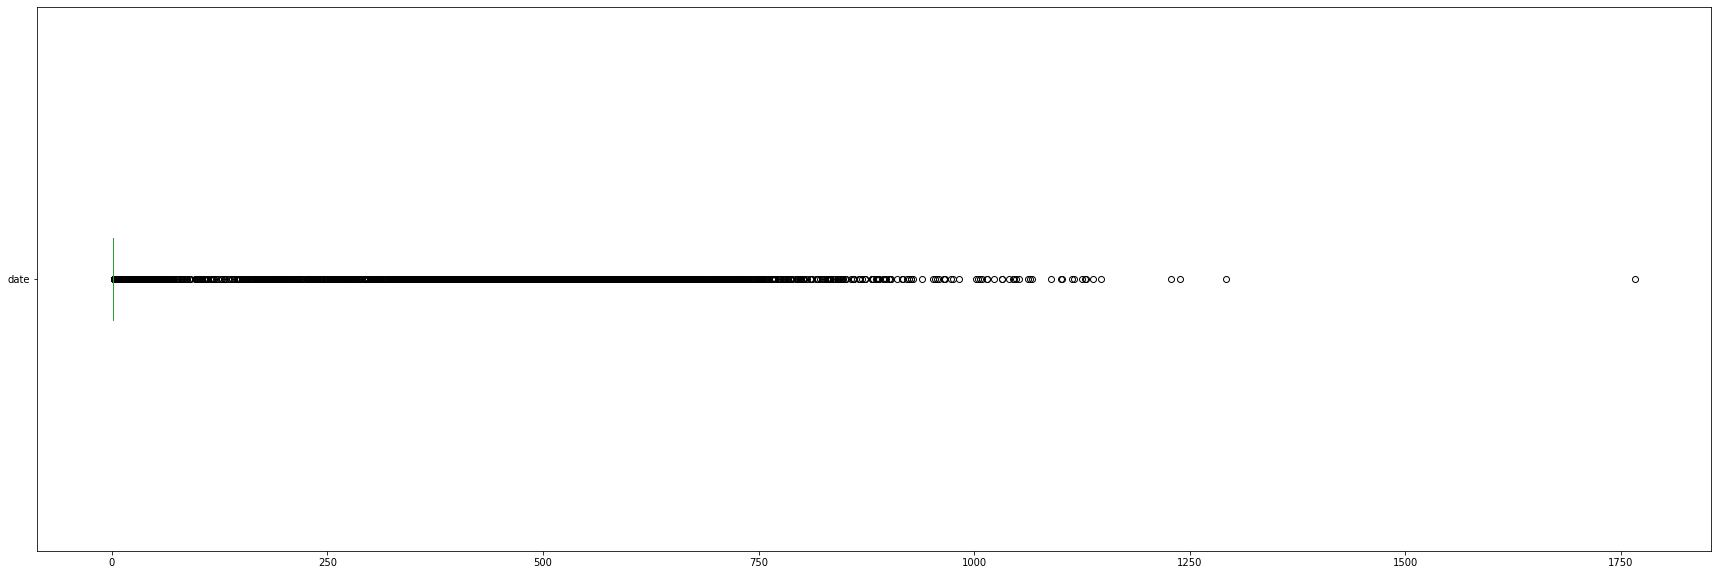

In [53]:
# BoxPlot of Date
data['date'].value_counts().plot.box(vert=False, figsize=(30,10))

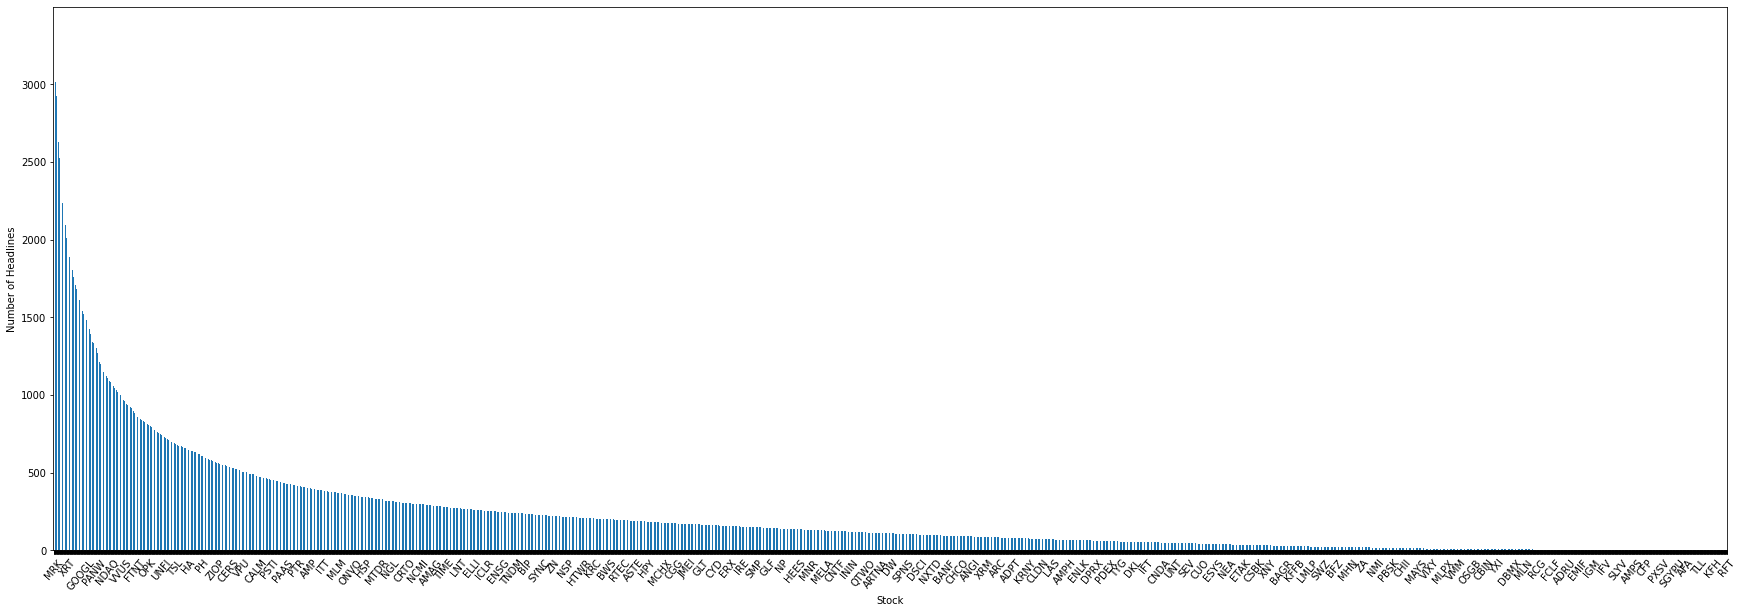

In [54]:
# Number of Headlines by Stock
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False)[0:6204].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

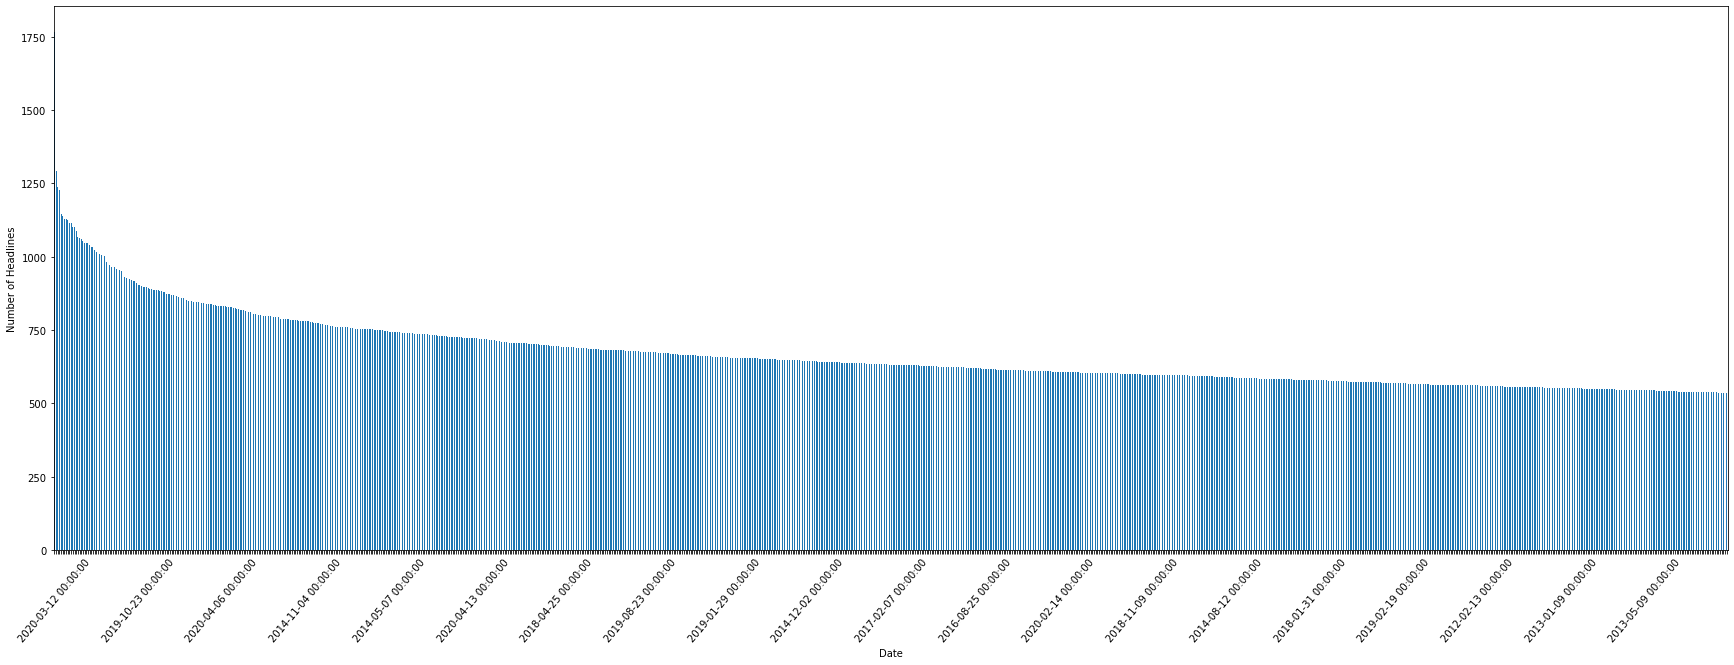

In [55]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False)[0:1000].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

#### Wordclouds

Ohne Bereinigung oder Stopword-Removal

WorldCloud over all Stocks, Top 50 Words:


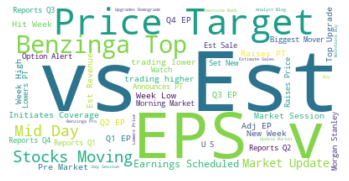

In [56]:
# Wordcloud for all Headlines together

# combine all headlines to one text
text = " ".join(headline for headline in data.headline)
maxWords = 50

# wordcloud
#!! No Stopword removal
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text)

# plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# save
wordcloud.to_file("./results/wordcloud.png")

WorldCloud for Random Stock: HUM, Top 50 Words:


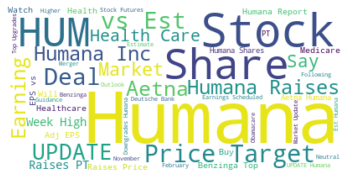

In [57]:
# Wordcloud for one random Stock

#combine all headlines of one Stock
stockFilter = random.choice(unique(data['stock']))
maxWords = 50
text_SpecificStock = " ".join(headline for headline in data[data["stock"]==stockFilter].headline)

#wordcloud
#!! No Stopword removal
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text_SpecificStock)

#plot
print("WorldCloud for Random Stock: " + stockFilter + ", Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud_stock-"+ stockFilter +".png")

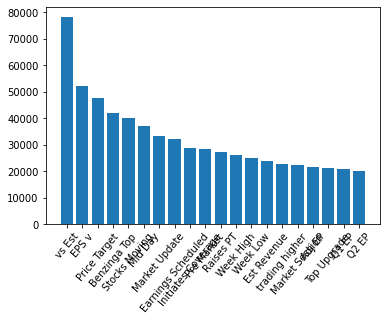

In [58]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

### Data Quality

In [59]:
# count all null values in the DataFrame
print("Anzahl von null Werten im gesamten DataFrame: "+str(data.isna().sum().sum()))
# count all dates without time, no need to format in isoFormat
print("Anzahl Zeitstempel ohne konkrete Uhrzeit: "+ str(data['date'].str.count('00:00:00').sum()))
# count duplicated
print("Anzahl Doppelten Einträgen: "+ str(data.duplicated().sum()))

Anzahl von null Werten im gesamten DataFrame: 0
Anzahl Zeitstempel ohne konkrete Uhrzeit: 1351341
Anzahl Doppelten Einträgen: 0


## Data Preparation

### Clean

In [60]:
# format datetime to date
data = data.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

# delete all rows older than 2years, because of API and Performance
data = data.drop(data[data.date < '2019-08-21'].index)


In [61]:
# clean the Stocks
# Remove Rows with Stocks that occur less than occ times
occ = 0
data = data[data.groupby('stock').stock.transform(len) > occ]

In [62]:
print("Der Datensatz erstreckt sich nun über einen Datumsspanne vom "+ data['date'].min() +" bis zum "+ data['date'].max() +"\nDabei besteht der Datensatz jetzt aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich nun über einen Datumsspanne vom 2019-08-21 bis zum 2020-06-11
Dabei besteht der Datensatz jetzt aus 164698 Einträgen


#### Headline Cleaning & Pre-Processing
Hier wird nochmal speziell jede einzelene Headline den typischen pre-processing Schritten unterzogen

##### Define Headline Preprocessing
Requierements and def of Functions

In [63]:
# Part Of Speech Tagging suppling lemmatization

def tokenize_post(headline):
    hl_tokenz = word_tokenize(headline)
    hl_post = nltk.pos_tag(hl_tokenz)
    hl_post_result = []
    for word in hl_post:
        if word[1].startswith('NN'):
            hl_post_result.append([word[0], 'n'])
        elif word[1].startswith('JJ'):
            hl_post_result.append([word[0], 'a'])
        elif word[1].startswith('V'):
            hl_post_result.append([word[0], 'v'])
        elif word[1].startswith('R'):
            hl_post_result.append([word[0], 'r'])
        else:
            hl_post_result.append([word[0], ''])
    return hl_post_result

In [64]:
# Stopword-removal
# Stopwords from NLTK Modul
def remove_stopwords(hl_post_tok_lower):
    stop_words = set(stopwords.words('english')) 

    # possible custom stopwords
    # stop_words.add('')

    filtered_sentence = [word for word in hl_post_tok_lower if not word[0] in stop_words]
    return filtered_sentence

In [65]:
# WortNetLemmatizer Function for lemmatization
lemmatizer = WordNetLemmatizer()

# this headline is pos-tagged, tokenzied, lower, and stopwords-removed
def lemmatize(headline):
    lemmatized_output = []
    for word in headline:
        if word[1] == '':
            lemmatized_output.append((lemmatizer.lemmatize(word[0]), word[1]))
        else:
            lemmatized_output.append((lemmatizer.lemmatize(word[0], pos=word[1]), word[1]))
    # remove less than two char
    lemmatized_output = [word for word in lemmatized_output if len(word[0]) > 2]
    # remove numeric
    lemmatized_output = [word for word in lemmatized_output if not word[0].isnumeric()]
    
    return lemmatized_output

In [66]:
# use most used synonym for the words, suppling Sentiments
def getSynset(headline):
    synset_output = []
    for word in headline:
        synsets = wn.synsets(word[0], pos=word[1])
        if len(synsets)>0:
            synset_output.append((synsets[0].name()))
        # remove word if no sentiment found
        # else:
        #     synset_output.append(word[0]+ "." +word[1]+".01")
    return synset_output

In [67]:
# calculate sentiment
senti_pos_score = []
senti_neg_score = []

senti_score = []

def getSentiment(headline):
    senti_pos = 0
    senti_neg = 0
    # senti_obj = 0
    for word in headline:
        swn_synset = swn.senti_synset(word)
        senti_pos += swn_synset.pos_score()
        senti_neg += swn_synset.neg_score()

    senti_pos_score.append(senti_pos)
    senti_neg_score.append(senti_neg)

    senti_score.append(senti_pos - senti_neg)
    # senti_obj_score.append(swn_synset.obj_score())
    return headline

##### Apply Headline Preprocessing

In [68]:
# headline as lowercase in a new colum
data['headline_cleaned'] = data['headline'].apply(lambda headline: headline.lower())

In [69]:
# tokenization und POS-Tagging
data['headline_cleaned'] = data['headline'].apply(tokenize_post)

In [70]:
# stopword-removal
data['headline_cleaned'] = data['headline_cleaned'].apply(remove_stopwords)

In [71]:
# lemmatization
data['headline_cleaned'] = data['headline_cleaned'].apply(lemmatize)

In [72]:
# replace by most used synonym
data['headline_cleaned'] = data['headline_cleaned'].apply(getSynset)

In [73]:
# calculate Sentiment
data['headline_cleaned'] = data['headline_cleaned'].apply(getSentiment)

# add Sentiment to DataFrame
data['senti_pos_score'] = senti_pos_score
data['senti_neg_score'] = senti_neg_score
data['senti_score'] = senti_score

In [74]:
#Export as csv for faster access
data.to_csv('../data/analyst_ratings_processed_hl_cleaned.csv', index=False)

### Construct

#### API call to get StockPrices for all stocks
verwendete API : 'https://polygon.io/' <br>
(benötigt Timeouts zwischen den API calls da die API max 5 Api calls pro Minute bedient)

In [75]:
# List of Stock Ticker to call
stocks_unique = unique(data['stock'])
print("Es verbleiben "+str(len(stocks_unique))+" eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen")

Es verbleiben 3807 eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen


In [ ]:
# API call with TimeOut (5 per minute)
key = os.environ.get("POLYGON_IO_API_KEY") # API key in .env
apiResults = []
apiCount = 0

for s in stocks_unique:
    # the API only response to 2years historical dates
    from_ = '2019-08-21'
    to =  '2020-12-31'

    # The API call
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(s, 1, "day", from_, to, unadjusted=False)
        # save the nessecary attributes of the JSON as List
        if (resp and hasattr(resp, 'results')):
            for result in resp.results:
                dt = datetime.datetime.fromtimestamp(result['t'] / 1000.0).isoformat()
                apiResults.append([s, dt, result['o'], result['h'], result['l'], result['c']])
        # if there are no results to a specific stock add it any ways to the List, so later the quality of the DataFrame can be controlled 
        else: 
            apiResults.append([s])
            print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___no_Results___")
    apiCount+=1
    print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___success___")
    time.sleep(12)

# save the List-Data as DataFrame
stock_prices = pd.DataFrame(apiResults, columns=['stock', 'date', 'open', 'high', 'low', 'close'])
# save the DataFrame as csv
stock_prices.to_csv('../data/raw_stock_prices.csv', encoding='utf-8', index=False)

In [76]:
#get the API data from the csv to DataFrame
stock_prices = pd.read_csv('../data/raw_stock_prices.csv')

##### Overview over the API Data

In [77]:
# count of the DataFrame
stock_prices.count()

stock    1227563
date     1227498
open     1227498
high     1227498
low      1227498
close    1227498
dtype: int64

In [78]:
# First Look
print(stock_prices.columns)
stock_prices.sample(7)

Index(['stock', 'date', 'open', 'high', 'low', 'close'], dtype='object')


stock                 date    open     high      low   close
546373   IBOC  2019-10-30T05:00:00   41.48   41.520   40.810   41.37
1011872  SMMF  2020-08-31T06:00:00   15.06   15.245   14.750   14.75
912559   QLYS  2019-10-16T06:00:00   78.69   78.690   76.800   78.41
335293    EDC  2019-10-09T06:00:00   64.00   64.640   63.710   63.90
1115629  TXRH  2020-06-30T06:00:00   53.39   53.610   51.640   52.57
743479   MUSA  2020-06-08T06:00:00  113.27  116.590  113.254  115.16
750926   MYRG  2020-03-09T05:00:00   28.18   28.500   25.520   25.98

In [79]:
# count NaN rows
nanStocks = stock_prices[stock_prices['open'].isna() & stock_prices['close'].isna()]['stock']
print("Total Count of Stocks with NaN: " + str(len(nanStocks)))

Total Count of Stocks with NaN: 65


#### Combine DataFrame
füge den open und den close Preis der Aktie zur Headline am gleichen Tag hinzu

In [80]:
# remove headlines with NaN stock prices
data = data.drop(data[data['stock'].isin(nanStocks)].index)

# remove NaN stocks
stock_prices = stock_prices.drop(stock_prices[stock_prices.open.isna() & stock_prices.close.isna()].index)

In [81]:
# format datetime to date as above for the data DataFrame
stock_prices = stock_prices.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

In [85]:
# remove headlines with date that are not covered by the stockprices -> probably Weekend
# datetime.datetime.fromisoformat().weekday() in [5,6]
data = data.drop(data[~data['date'].isin(stock_prices['date'])].index) # ~ means NOT IN
print('Anzahl der Aktien im DataFame der Aktienpreise die, nach dem bereinigen, Null sind:\n', stock_prices.isna().sum())

Anzahl der Aktien im DataFame der Aktienpreise die, nach dem bereinigen, Null sind:
 stock    0
date     0
open     0
high     0
low      0
close    0
dtype: int64


In [86]:
# Merge to the Final DataFrame
data = pd.merge(data, stock_prices[['stock', 'date', 'open', 'close']], on=['stock', 'date'])

#### Calculate Binary
##### Sentiment and Stockprice change
positive Sentiment = 1;
neutral Sentiment = 0;
negative Sentiment = -1

Stock Price Increase by more than x = 1;
Stock Price doesnt change more than x = 0;
Stock Price Decrease by more than x = -1

In [87]:
# calculate absolute values for the Stock Movement between [-1,1]
x=0.01
def stockDevelopment(row):
    # stock_differenz = row['open'] - row['close']
    quotient = row['close']/row['open']
    if quotient < (1-x):
        return -1
    elif quotient > (1+x):
        return 1
    else: return 0

In [88]:
# calculate absolute values for the Sentiment between [-1,1]
def getBinarySenti(row):
    if row["senti_score"] < 0:
        return -1
    elif row['senti_score'] > 0:
        return 1
    else: return 0

In [89]:
# add new colum with the "binary" Stockprice change
data["stockPrice_Change"] = data.apply(stockDevelopment, axis=1)

In [90]:
# add new colum with the "binary" Sentiment
data['senti_Binary'] = data.apply(getBinarySenti, axis=1)

In [11]:
print(data.columns)
data.drop(columns=['publisher', 'url']).sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock',
       'headline_cleaned', 'senti_pos_score', 'senti_neg_score', 'senti_score',
       'open', 'close', 'stockPrice_Change', 'senti_Binary'],
      dtype='object')


id                                           headline  \
13699    109049  Shares of several technology companies are tra...   
90654    801222  Baird Maintains Outperform on Masco, Lowers Pr...   
141073  1246280  Mid-Afternoon Market Update: DexCom Gains Foll...   
100884   892731  Shares of several utility companies are tradin...   
55386    480495  Piper Sandler Downgrades First Commonwealth to...   
146311  1274599          Stocks That Hit 52-Week Lows On Wednesday   
113312   991211  MKM Partners Maintains Buy on PDC Energy, Lowe...   

              date stock                                   headline_cleaned  \
13699   2020-01-28  ATVI  ['share.n.01', 'several.s.01', 'technology.n.0...   
90654   2019-09-18   MAS  ['lower_berth.n.01', 'monetary_value.n.01', 't...   
141073  2019-11-07  TOPS  ['market.n.01', 'update.n.01', 'derive.v.02', ...   
100884  2020-03-16   NEE  ['share.n.01', 'several.s.01', 'utility.n.01',...   
55386   2020-05-01   FCF  ['piper.n.01', 'downgrade.n.01', 'first.n.01',...   
146311  2020-03-18   TWO  ['stock.n.01', 'hit.v.01', 'low.n.01', 'wednes...   
113312  2020-03-03  PDCE  ['spouse.n.01', 'bargain.n.02', 'energy.n.01',...   

        senti_pos_score  senti_neg_score  senti_score   open    close  \
13699             0.375            1.750       -1.375  58.79  60.0300   
90654             0.000            0.125       -0.125  40.54  41.4800   
141073            0.125            0.000        0.125  37.00  30.7500   
100884            0.125            2.500       -2.375  49.50  50.3425   
55386             0.000            0.250       -0.250   8.86   8.8000   
146311            0.000            0.000        0.000   7.60   5.6900   
113312            0.500            0.125        0.375  18.56  17.5300   

        stockPrice_Change  senti_Binary  
13699                   0            -1  
90654                   0            -1  
141073                 -1             1  
100884                  0            -1  
55386                   0            -1  
146311                 -1             0  
113312                  0             1

### Export The Final DataFrame

In [91]:
# export final DataSet as csv
data.to_csv('../data/analyst_ratings_processed_final.csv', index=False)

In [92]:
# import final DataSet for Modelling
data = pd.read_csv('../data/analyst_ratings_processed_final.csv')

### Overview

#### Final Look

In [93]:
# final Look
print(data.columns)
data.drop(columns=['publisher', 'url']).sample(7) #drop the colum just for the sample for better overview

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock',
       'headline_cleaned', 'senti_pos_score', 'senti_neg_score', 'senti_score',
       'open', 'close', 'stockPrice_Change', 'senti_Binary'],
      dtype='object')


id                                           headline  \
99227    878638            Stocks That Hit 52-Week Highs On Friday   
122274  1075275            Stocks That Hit 52-Week Highs On Monday   
137515  1216543  DA Davidson Analyst Rishi Jaluria Attributes W...   
84228    747318  Canaccord Genuity Maintains Buy on Kratos Defe...   
124342  1095384                   80 Biggest Movers From Yesterday   
93968    832388  Wells Fargo Downgrades Martin Midstream Partne...   
114791  1003655  PennyMac Financial Services shares are trading...   

              date stock                                   headline_cleaned  \
99227   2020-02-21   MYI  ['stocks.n.01', 'hit.v.01', 'high.n.01', 'frid...   
122274  2020-05-18  REGN  ['stocks.n.01', 'hit.v.01', 'high.n.01', 'mond...   
137515  2019-09-09   TDC  ['analyst.n.01', 'property.n.04', 'failing.n.0...   
84228   2020-02-25  KTOS  ['bargain.n.02', 'defense.n.01', 'security.n.0...   
124342  2020-02-19  RMTI     ['large.a.01', 'mover.n.01', 'yesterday.n.01']   
93968   2020-01-07  MMLP  ['wells.n.01', 'fargo.n.01', 'downgrade.n.01',...   
114791  2020-04-13  PFSI  ['services.n.01', 'share.n.01', 'trade.v.01', ...   

        senti_pos_score  senti_neg_score  senti_score    open   close  \
99227             0.125            0.000        0.125   14.07   14.11   
122274            0.125            0.000        0.125  582.00  560.28   
137515            0.500            0.375        0.125   32.41   33.32   
84228             1.000            0.250        0.750   17.46   15.00   
124342            0.250            0.125        0.125    2.95    2.95   
93968             0.000            0.000        0.000    4.06    4.20   
114791            1.000            0.625        0.375   26.71   26.61   

        stockPrice_Change  senti_Binary  
99227                   0             1  
122274                 -1             1  
137515                  1             1  
84228                  -1             1  
124342                  0             1  
93968                   1             0  
114791                  0             1

In [94]:
# some statistics about the final DataFrame
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))
data.count()

observations: 161478, features: 14 

unique headlines: 76162, unique stocks: 3722 



id                   161478
headline             161478
url                  161478
publisher            161478
date                 161478
stock                161478
headline_cleaned     161478
senti_pos_score      161478
senti_neg_score      161478
senti_score          161478
open                 161478
close                161478
stockPrice_Change    161478
senti_Binary         161478
dtype: int64

#### Visialization
Verteilung und Menge

<AxesSubplot:>

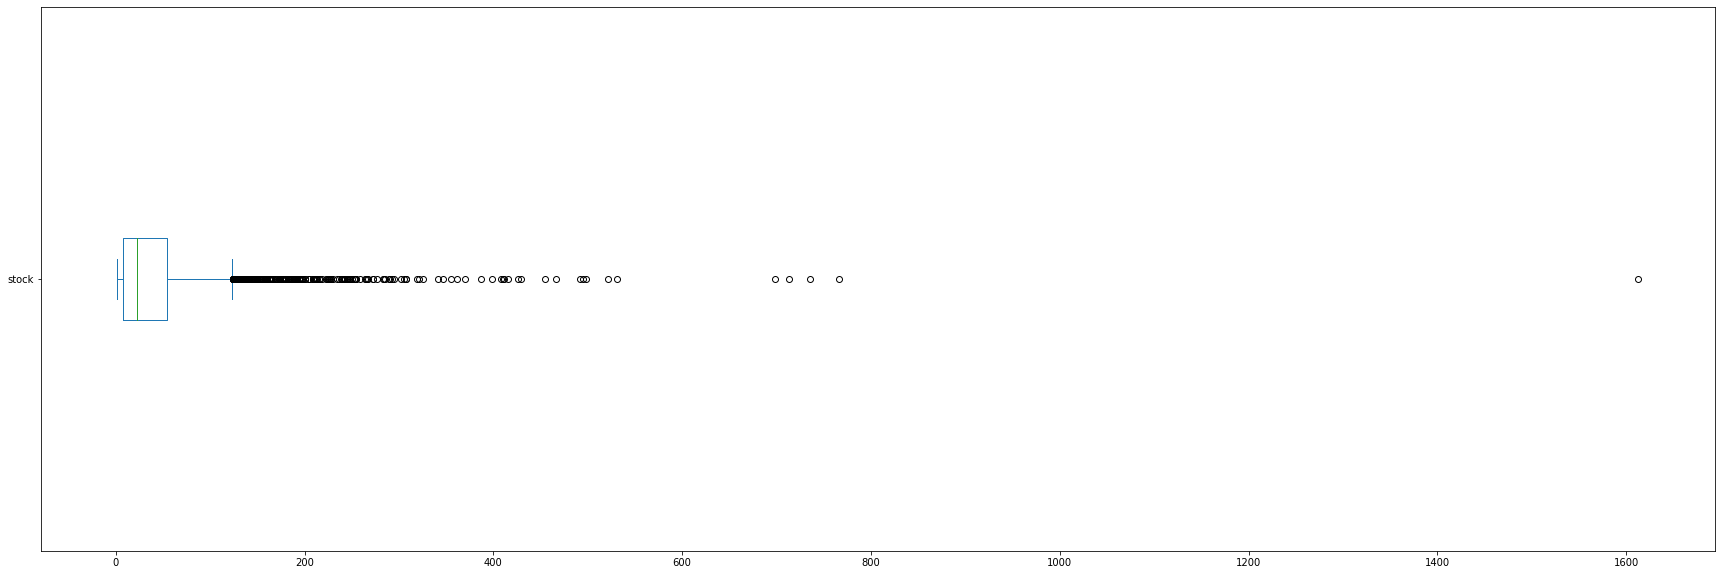

In [95]:
# BoxPlot of Stocks as above
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

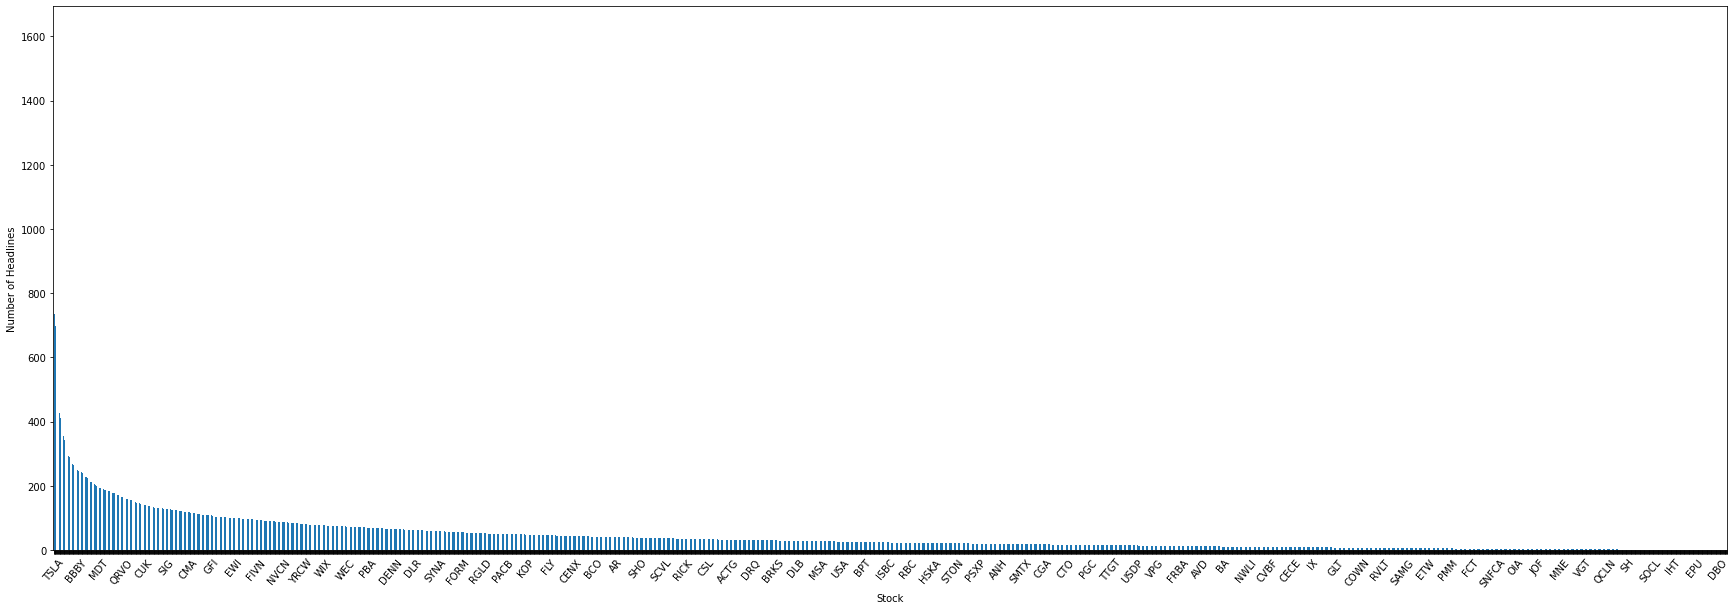

In [96]:
stock = data.groupby("stock")

# Number of Headlines by Stock as above
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

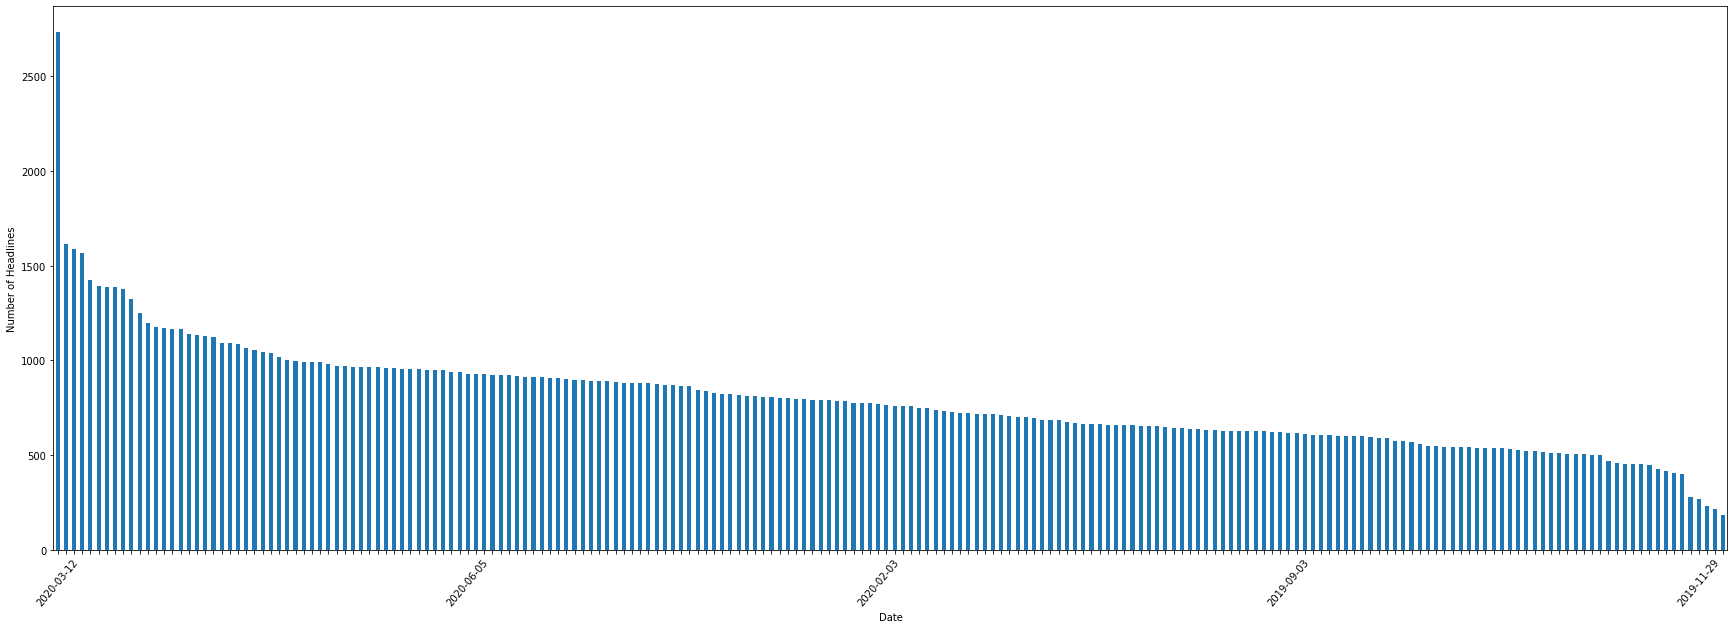

In [97]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")

#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

#### Wordcloud
Nach dem Bereinigen der Daten, inkl. Stopword Removal

WorldCloud over all Stocks, Top 50 Words:


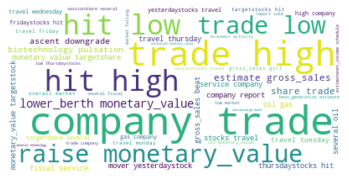

In [98]:
# Wordcloud for all Headlines

# combine all headlines to one text
text_afterCleaning = " "
for headline in data.headline_cleaned:
    text_afterCleaning = text_afterCleaning + ' '.join(list(map(lambda s: s.strip()[1:-5].replace('.',''), headline[1:-1].split(','))))

maxWords = 50
# wordcloud
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text_afterCleaning)

# plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# save
wordcloud.to_file("./results/wordcloud_afterCleaning.png")

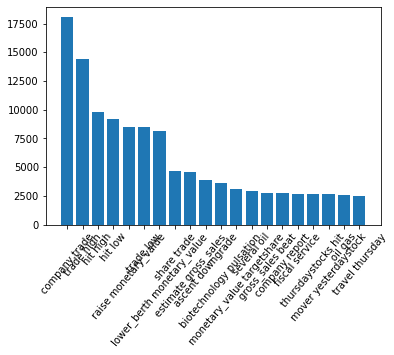

In [99]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text_afterCleaning)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

## Modelling

### Simple Corellation
Überprüfe ob der Aktienpreis direkt mit dem Sentiment der Überschrift der Aktiennews zusammenhängt

positive correlation = 1 (sentiment == Positive -> stock price increase; sentiment == Negative -> stock price decrease); <br>
negative correlation = -1 (sentiment == Positive -> stock price decrease; sentiment == Negative -> stock price increase); <br>
neutral correlation = 0 (senti_Binary == 0 and stockPrice_Change == 0)

In [4]:
# calculate Correlation
def checkCorrelation(row):
    if ((row['stockPrice_Change'] != row["senti_Binary"]) and (row['stockPrice_Change'] != 0) and (row["senti_Binary"] !=0)):
        return -1
    if row['stockPrice_Change'] == row["senti_Binary"]:
        return 1
    else: return 0

In [5]:
# add correlation to DataFrame as new colum
data["correlation"] = data.apply(checkCorrelation, axis=1)

In [6]:
# calculate 'accuracy' of positive correlation
countRow_Pos = data[data["correlation"] == 1].shape[0]
countRow = data.shape[0]
accuracy = countRow_Pos / countRow
print("Von " + str(countRow) + " Headlines mit Sentiment-Score korrelieren " + str(countRow_Pos) +" positiv mit einem Aktienanstieg.\nDas ergbit eine Accuracy von: " + str(accuracy))

Von 161478 Headlines mit Sentiment-Score korrelieren 61517 positiv mit einem Aktienanstieg.
Das ergbit eine Accuracy von: 0.3809621124859114


In [7]:
# calculate 'accuracy' of negative correlation
countRow_Neg = data[data["correlation"] == -1].shape[0]
countRow = data.shape[0]
accuracy = countRow_Neg / countRow
print("Von " + str(countRow) + " Headlines mit Sentiment-Score korrelieren " + str(countRow_Neg) +" negativ mit einem Aktienanstieg.\nDas ergbit eine Accuracy von: " + str(accuracy))

Von 161478 Headlines mit Sentiment-Score korrelieren 3520 negativ mit einem Aktienanstieg.
Das ergbit eine Accuracy von: 0.02179863510818811


In [8]:
# remove the above column from the DataFrame
data = data.drop(columns=['correlation'])

### Linear Regression based on the Sentimentscore

Im folgenden werden ein paar Lineare-Regressionsmodelle aufgebaut und mit einander Verglichen. <br>
Die Regressionsmodelle unterscheiden sich dabei in den Predictoren, welche alle sam taus dem Datensatz entnommen werden.

In [9]:
# Split the DataFrame in Train and Test Data
splitted_set = train_test_split(data, test_size=0.3)
train_set = splitted_set[0]
test_set = splitted_set[1]

In [10]:
# Targetvariable
Y = train_set['stockPrice_Change']
Y = np.array(list(Y))

In [ ]:
# standardization of the predicted values
def standardization(pred):
    pred = pred * 10
    if pred <= 0.5 and pred >= -0.5: return 0
    if pred > 0.5: return 1
    if pred < 0.5: return -1

#### simple Regression by senti_score

In [12]:
# only use the senti_score as Predictor on the train_set
X_sentiScore = train_set['senti_score'] 
# need 2D Array
X_sentiScore = np.array(list(X_sentiScore)).reshape((-1, 1))

In [13]:
# Model just with senti_score
model_sentiScore = LinearRegression().fit(X_sentiScore,Y)

In [ ]:
# apply the prediction to the test_set
test_set["prediction_sentiScore"] = test_set.apply(lambda row: model_sentiScore.predict([[row['senti_score']]])[0], axis=1)

In [ ]:
# standartization of the preditcitons in the test_set
test_set["prediction_sentiScore"] = test_set["prediction_sentiScore"].apply(standardization)

#### simple Regression by senti_pos_score and senti_neg_score

In [14]:
# senti_score as Positive and negative as Predictor on the train_set
X_sentiPosNeg = train_set[['senti_pos_score', 'senti_neg_score']].values.tolist()

In [15]:
# Model with pos and neg senti
model_sentiPosNeg = LinearRegression().fit(X_sentiPosNeg,Y)

In [ ]:
# apply the prediction to the test_set
test_set["prediction_sentiPosNeg"] = test_set.apply(lambda row: model_sentiPosNeg.predict([row[['senti_pos_score', 'senti_neg_score']].values.tolist()])[0], axis=1)

In [ ]:
# standartization of the preditcitons in the test_set
test_set["prediction_sentiPosNeg"] = test_set["prediction_sentiPosNeg"].apply(standardization)

#### simple Regression by senti_pos_score and senti_neg_score and open

In [18]:
# pos and neg senti_score and the open Price as Predictor on the train_set
X_wOpen = train_set[['senti_pos_score', 'senti_neg_score', 'open']].values.tolist()

In [19]:
# Model with pos and neg senti
model_wOpen = LinearRegression().fit(X_wOpen,Y)

In [ ]:
# apply the prediction to the test_set
test_set["prediction_wOpen"] = test_set.apply(lambda row: model_wOpen.predict([row[['senti_pos_score', 'senti_neg_score', 'open']].values.tolist()])[0], axis=1)

In [ ]:
# standartization of the preditcitons in the test_set
test_set["prediction_wOpen"] = test_set["prediction_wOpen"].apply(standardization)

#### simple Regression by senti_pos_score and senti_neg_score and count of Publication

In [32]:
# calculate the count of publications to the stock on the day of publication
# incl Progressbar
countTimer = 1
def calPublishCount(row):
    global countTimer
    count = data[(data['stock'] == row['stock']) & (data['date'] == row['date'])]['id'].count()

    #print Progress
    progress = (countTimer/161478)*100
    #sys.stdout.write("\r[ %s ]%d%%" % ('#'*(int(progress/1))+'-'*(100-int(progress/1)), progress))
    sys.stdout.write("\r[ %s ]%d%% ::: %d out of %d, id: %d: %d" % ('#'*(int(progress/1))+'-'*(100-int(progress/1)), progress, countTimer, 161478, row['id'], count))
    sys.stdout.flush()
    countTimer += 1

    return count

In [ ]:
# add the count of publications to the stock on the day as news colum
data['publish_count'] = data.apply(calPublishCount, axis=1)
# export the extended DataFrame
data.to_csv('../data/analyst_ratings_processed_final_count.csv', index=False)

In [7]:
# import the extended DataFrame
data = pd.read_csv('../data/analyst_ratings_processed_final_count.csv')
#!!! repeat the test_train_split here!!!!

In [16]:
# pos and neg senti_score and publish_count as Predictor on the train_set
X_wPublishCount = train_set[['senti_pos_score', 'senti_neg_score', 'publish_count']].values.tolist()

In [17]:
# Model with pos and neg senti as also the count of publications to the stock on the day
model_wPublishCount = LinearRegression().fit(X_wPublishCount,Y)

In [ ]:
# apply the prediction to the test_set
test_set["prediction_wPublishCount"] = test_set.apply(lambda row: model_wPublishCount.predict([row[['senti_pos_score', 'senti_neg_score', 'publish_count']].values.tolist()])[0], axis=1)

In [ ]:
# standartization of the preditcitons in the test_set
test_set["prediction_wPublishCount"] = test_set["prediction_wPublishCount"].apply(standardization)

#### Evaluation

In [25]:
ModelEvaluationRow = ['senti_score', 'senti_pos_score, senti_neg_score', 'with open', 'with PublishCount']
ModelEvaluationCol = ['intercept', 'slope', 'coefficient / R^2', 'accuracy', 'rmse']

ModelEvaluation_sentiScore = [model_sentiScore.intercept_, model_sentiScore.coef_, model_sentiScore.score(X_sentiScore, Y), test_set[test_set['prediction_sentiScore'] == test_set['stockPrice_Change']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Change']), list(test_set['prediction_sentiScore']), squared=False)]
ModelEvaluation_sentiPosNeg = [model_sentiPosNeg.intercept_, model_sentiPosNeg.coef_, model_sentiPosNeg.score(X_sentiPosNeg, Y), test_set[test_set['prediction_sentiPosNeg'] == test_set['stockPrice_Change']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Change']), list(test_set['prediction_sentiPosNeg']), squared=False)]

ModelEvaluation_wOpen = [model_wOpen.intercept_, model_wOpen.coef_, model_wOpen.score(X_wOpen, Y), test_set[test_set['prediction_wOpen'] == test_set['stockPrice_Change']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Change']), list(test_set['prediction_wOpen']), squared=False)]
ModelEvaluation_wPublishCount = [model_wPublishCount.intercept_, model_wPublishCount.coef_, model_wPublishCount.score(X_wPublishCount, Y), test_set[test_set['prediction_wPublishCount'] == test_set['stockPrice_Change']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Change']), list(test_set['prediction_wPublishCount']), squared=False)]

ModelEvaluation = [ModelEvaluation_sentiScore, ModelEvaluation_sentiPosNeg, ModelEvaluation_wOpen, ModelEvaluation_wPublishCount]

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


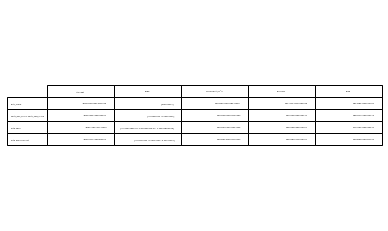

In [26]:
fig, ax = plt.subplots()

# Hide axes
fig.patch.set_visible(False)
ax.axis('off')

table = ax.table(ModelEvaluation, colLabels=ModelEvaluationCol, rowLabels=ModelEvaluationRow, loc='center')
table.set_fontsize(16)
# table.scale(1,1.5)

plt.show()

#### Export Linear Regression Sentiment Model

In [16]:
import joblib
joblib.dump(model_sentiPosNeg, './deployment/model.pkl')

['./deployment/model.pkl']

### TF-IDF

### Evaluation